# Experiment 3: Aggregation choices can flip the winner

This notebook reproduces **Experiment 3** from our paper on validation pitfalls in surgical AI.  
It demonstrates how **different aggregation strategies across hierarchical levels** can substantially alter **algorithm rankings**, including flipping the apparent winner.


## Core idea

Surgical video analysis data is inherently **multi-level**:
- individual **frames**
- grouped into **surgical phases**
- nested within **patient cases / videos**

Reported performance scores and rankings depend on **how results are aggregated across these levels**. However, aggregation schemes are often **underspecified or omitted entirely** in the literature.

In this experiment, we show that different, yet reasonable, aggregation strategies applied to the same fixed frame-level results can lead to **substantially different rankings**, including changes in the top-ranked algorithm.

## Experimental setup

We analyze results from the **binary instrument segmentation task** of the **RobustMIS 2019 challenge**, focusing exclusively on:

- **Stage 3** (sigmoid resection), the held-out test set
- **Frame-level Dice Similarity Coefficient (DSC)** scores
- **Ten participating algorithms**

No models are trained or re-evaluated. All analyses are **deterministic re-aggregations** of the same underlying results.

## Aggregation strategies

We compare six aggregation strategies commonly (explicitly or implicitly) used in practice:

1. **Frame-wise aggregation**  
   Performance is aggregated equally over all frames across all videos.  
   This reflects common practice and was used in the original challenge.

2. **Video-wise aggregation**  
   Performance is aggregated per video over frames, then aggregated across videos.

3. **Phase-wise aggregation**  
   Performance is aggregated per surgical phase over frames, then averaged across phases.

4. **Phase-wise video-wise aggregation**  
   Performance is first aggregated per phase *within* each video.  
   Rankings are then aggregated across videos per phase, and finally across phases.

5. **Video-wise phase-wise aggregation**  
   Performance is first aggregated per phase *within* each video.  
   Rankings are then aggregated across phases per video, and finally across videos.

6. **Weighted phase-wise aggregation**  
   Performance is aggregated per phase and combined using clinician-defined phase weights
   reflecting clinical relevance and complexity.

Across all strategies, the **aggregation operator** is fixed to the **5th percentile**, consistent with the original RobustMIS challenge, to reflect worst-case performance.

## Ranking comparison

To quantify how strongly rankings differ between aggregation strategies, we compare each alternative ranking to the default **frame-wise ranking** using:

- **Kendall’s tau rank correlation coefficient**  
  - τ = 1: perfect agreement  
  - τ = 0: no association  
  - τ = –1: complete disagreement

We additionally quantify:
- absolute rank changes
- direction of rank shifts
- frequency of winner changes

## Reproducibility notes

- All aggregation strategies are implemented **explicitly** in this notebook.
- No randomness is involved; results are **fully deterministic**.
- No raw images or annotations are accessed.

## Software dependencies

This notebook uses standard Python libraries for data handling, statistical resampling, metric computation, and visualization. All required imports are listed explicitly below.

## How to run

Run the notebook **top-to-bottom** (Kernel --> Restart & Run All). 

If paths need adjustment, do so in the dedicated "data loading" section only.

In [1]:
# =========================
# core libraries
# =========================
import numpy as np
import pandas as pd

# =========================
# statistics
# =========================
from scipy.stats import kendalltau

# =========================
# plotting
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading and structure

This experiment is based on **frame-level performance results** from the **RobustMIS 2019 challenge**, 
binary instrument segmentation task.

Only tabular result files are required; no images, videos, or segmentation masks are accessed.

### RobustMIS (binary instrument segmentation)

- **Challenge stage:** Stage 3 (sigmoid resection only)
- **Metric:** Dice Similarity Coefficient (DSC)
- **Algorithms:** 10 challenge submissions
- **Hierarchy levels:**
  - `frame`: individual video frames
  - `phase`: surgical phase label
  - `surgery_number`: patient / surgery case

All subsequent analyses operate on this single table and differ **only** in how results are aggregated across these hierarchy levels.

In [2]:
# Load RobustMIS frame-level results
robustmis_data= pd.read_csv('robustmis_results_binary_segmentation_anonym.csv')

# Extract list of algorithms
teams = sorted(robustmis_data["team_name"].unique())

print(robustmis_data[['surgery_number', 'frame', 'team_name']].nunique())

robustmis_data

surgery_number      10
frame             2231
team_name           10
dtype: int64


,Unnamed: 0,surgery_type,surgery_number,frame_nr,phase,frame,stage,task,team_name,DSC,NSD,surgery
0,10091,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A1,0.936055,0.947957,Sigma_1
1,10092,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A9,0.000000,0.000000,Sigma_1
2,10093,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A8,0.921258,0.954009,Sigma_1
3,10094,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A2,0.972946,0.984471,Sigma_1
4,10095,Sigma,1,1500,0,1500_Sigma_1,Stage_3,Testcase.BINARY_SEGMENTATION,A10,0.939981,0.953592,Sigma_1
...,...,...,...,...,...,...,...,...,...,...,...,...
22305,32396,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A7,0.596940,0.645750,Sigma_10
22306,32397,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A3,0.926841,0.989964,Sigma_10
22307,32398,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A6,0.643824,0.693771,Sigma_10
22308,32399,Sigma,10,232912,12,232912_Sigma_10,Stage_3,Testcase.BINARY_SEGMENTATION,A4,0.904129,0.980065,Sigma_10


## Aggregation and ranking strategies

This section implements the aggregation strategies. All strategies operate on the same fixed frame-level results and differ only in how scores are aggregated across hierarchy levels (frames, phases, videos).

### Aggregation operator

Across all strategies, we use the **5th percentile** as aggregation operator, consistent with the original RobustMIS challenge.
This choice emphasizes worst-case performance rather than average behavior.

### Ranking principle

For each aggregation strategy:

1. Frame-level DSC scores are aggregated according to the specified hierarchy.
2. Algorithms are ranked based on the aggregated scores.
3. Ties are resolved using the minimum rank convention.

In [3]:
def percentile_5(x):
    """
    Compute the 5th percentile of a vector.
    """
    return np.percentile(x, 5)

In [4]:
def frame_wise_ranking(df, agg_func):
    """
    Compute a frame-wise ranking by aggregating the frame-level performance (here: DSC scores) per team across all frames 
    in the test set and derive a global ranking. 

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least the columns:
        - 'team_name' : identifier of the algorithm/team
        - 'DSC'       : frame-level performance metric.
    agg_func : callable
        Aggregation operator (e.g., 5th percentile).

    Returns
    -------
    pandas.DataFrame
        Aggregated score and rank per algorithm.
    """
    
    scores = df.groupby("team_name")["DSC"].apply(agg_func).reset_index(name="Score")
    
    # Higher DSC implies better performance
    scores["Rank"] = scores["Score"].rank(ascending=False, method="min").astype(int)
    return scores

In [5]:
def video_wise_ranking(df, agg_func):
    """
    Compute a video-wise ranking. For each video, team-wise performance is aggregated first and converted
    into ranks. These ranks are then aggregated across videos to obtain a final ranking. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least the columns:
        - 'team_name' : identifier of the algorithm/team
        - 'DSC'       : frame-level performance metric
        - 'surgery_number' : video identifier
    agg_func : callable
        Aggregation operator (e.g., 5th percentile).

    Returns
    -------
    pandas.DataFrame
        Aggregated rank and final rank per algorithm.
    """
    per_video_ranks = []

    for _, df_video in df.groupby("surgery_number"):
        scores_video = df_video.groupby("team_name")["DSC"].apply(agg_func)
        ranks_video = scores_video.rank(ascending=False, method="min")
        per_video_ranks.append(ranks_video)

    # Each column corresponds to one video
    per_video_ranks = pd.concat(per_video_ranks, axis=1)
    
    mean_ranks = per_video_ranks.mean(axis=1)

    result = mean_ranks.reset_index(name="MeanRank")
    result["Rank"] = result["MeanRank"].rank(method="min").astype(int)
    
    return result

In [6]:
def phase_wise_ranking(df, agg_func):
    """
    Compute a phase-wise ranking. For each surgical phase, team-wise performance is aggregated and ranked.
    Ranks are then aggregated across phases. 
    
    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least the columns:
        - 'team_name' : identifier of the algorithm/team
        - 'DSC'       : frame-level performance metric
        - 'phase'     : surgical phase identifier
    agg_func : callable
        Aggregation operator (e.g., 5th percentile).

    Returns
    -------
    pandas.DataFrame
        Aggregated rank and final rank per algorithm.
    """
    per_phase_ranks = []

    for _, df_phase in df.groupby("phase"):
        scores_phase = df_phase.groupby("team_name")["DSC"].apply(agg_func)
        ranks_phase = scores_phase.rank(ascending=False, method="min")
        per_phase_ranks.append(ranks_phase)

    per_phase_ranks = pd.concat(per_phase_ranks, axis=1)
    mean_ranks = per_phase_ranks.mean(axis=1)

    result = mean_ranks.reset_index(name="MeanRank")
    result["Rank"] = result["MeanRank"].rank(method="min").astype(int)
    
    return result

In [7]:
def per_phase_per_video_rankings(df, teams, agg_func):
    """
    Compute phase-wise, video-wise rankings as an intermediate representation. For each (phase, video) combination, 
    team-wise performance is aggregated and converted into ranks. The resulting table serves as input for
    higher-level aggregation schemes (e.g. phase-wise-video-wise or video-wise-phase-wise rankings).

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain at least the columns:
        - 'team_name' : identifier of the algorithm/team
        - 'DSC'       : frame-level performance metric.
        - 'phase'     : surgical phase identifier
        - 'surgery_number' : video identifier
    teams : list
        List of all team names.
    agg_func : callable
        Aggregation operator (e.g., 5th percentile).

    Returns
    -------
    pandas.DataFrame
        Rows correspond to teams (in sorted order), columns correspond to rank.phase.<phase>.Sigma_<video>.
    """

    teams_sorted = sorted(teams)

    # Aggregate DSC per (phase, video, team)
    per_phase_video_scores = (
        df.groupby(["phase", "surgery_number", "team_name"])["DSC"]
          .agg(agg_func).rename("Score").reset_index()
    )

    # Convert scores to ranks within each (phase, video)
    per_phase_video_scores["Rank"] = (
        per_phase_video_scores
        .groupby(["phase", "surgery_number"])["Score"].rank(ascending=False, method="min").astype(int)
    )

    # Pivot to wide format (teams as rows, one column per phase/video)
    wide_ranks = (
        per_phase_video_scores
        .pivot(index="team_name", columns=["phase", "surgery_number"], values="Rank").reindex(teams_sorted)
    )

    # Rename columns
    wide_ranks.columns = [f"rank.phase.{phase}.Sigma_{surgery_number}"
        for (phase, surgery_number) in wide_ranks.columns.to_list()
    ]

    result = wide_ranks.reset_index().rename(columns={"team_name": 0})
    
    return result

In [8]:
def phase_wise_video_wise_ranking(df, teams, phase_video_rankings):
    """
    Aggregate phase-wise video-wise rankings. For each phase, ranks are first aggregated across videos. These phase-level
    ranks are then aggregated across phases to obtain a final ranking.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain column 'phase'.
    teams : list
        List of all team names.
    phase_video_rankings : pandas.DataFrame
        Output of per_phase_per_video_rankings.

    Returns
    -------
    pandas.DataFrame
        Aggregated rank and final rank per algorithm.
    """
    teams_sorted = sorted(teams)
    phases = df["phase"].unique()

    phase_to_cols = {
        p: [c for c in phase_video_rankings.columns
            if isinstance(c, str) and c.startswith(f"rank.phase.{p}.")]
        for p in phases
    }

    # Compute phase-level ranks (one column per phase)
    phase_level_ranks = pd.DataFrame(index=range(len(teams_sorted)))

    for p, cols in phase_to_cols.items():
        mean_ranks = phase_video_rankings[cols].mean(axis=1)
        phase_level_ranks[p] = mean_ranks.rank(method="min")

    mean_rank = phase_level_ranks.mean(axis=1)
    final_rank = mean_rank.rank(method="min")

    result = pd.DataFrame({
        "Category": teams_sorted,
        "MeanRank": mean_rank.values,
        "Rank": final_rank.astype(int).values
    })

    return result[["Category", "MeanRank", "Rank"]]

In [9]:
def video_wise_phase_wise_ranking(df, teams, phase_video_rankings):
    """
    Aggregate video-wise phase-wise rankings. For each video, ranks are averaged across phases first. 
    These video-level ranks are then aggregated across videos. 

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain column 'surgery_number'.
    teams : list
        List of all team names.
    phase_video_rankings : pandas.DataFrame
        Output of per_phase_per_video_rankings.

    Returns
    -------
    pandas.DataFrame
        Aggregated rank and final rank per algorithm.
    """
    teams_sorted = sorted(teams)
    videos = df["surgery_number"].unique()

    video_to_cols = {
        v: [c for c in phase_video_rankings.columns
            if isinstance(c, str) and c.startswith("rank.phase.") and c.endswith(f"Sigma_{v}")]
        for v in videos
    }

    # Compute video-level ranks (one column per video)
    video_level_ranks = pd.DataFrame(index=range(len(teams_sorted)))

    for v, cols in video_to_cols.items():
        mean_ranks = phase_video_rankings[cols].mean(axis=1)
        video_level_ranks[v] = mean_ranks.rank(method="min")

    mean_rank = video_level_ranks.mean(axis=1)
    final_rank = mean_rank.rank(method="min")

    result = pd.DataFrame({
        "Category": teams_sorted,
        "MeanRank": mean_rank.values,
        "Rank": final_rank.astype(int).values
    })

    return result[["Category", "MeanRank", "Rank"]]

In [10]:
def weighted_phase_wise_ranking(df, teams, agg_func):
    """
    Compute a weighted phase-wise ranking. Team-wise performance is aggregated and ranked per phase. Phase-specific
    ranks are then combined using a predefined weight vector reflecting clinician-informed relevance of phases.

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain columns:
        - 'team_name' : identifier of the algorithm/team
        - 'DSC'       : frame-level performance metric.
        - 'phase'     : surgical phase identifier
    teams : list
        List of all team names.
    agg_func : callable
        Aggregation operator applied per team and phase.

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns:
        - team_name
        - MeanRank : weighted mean of phase-wise ranks
        - Rank     : final rank (ties = min)
    """
    teams = list(sorted(teams))
    per_phase_rankings = pd.DataFrame({"Algorithm": teams})

    for phase in df["phase"].unique():
        df_p = df[df["phase"] == phase]
        scores_phase = df_p.groupby("team_name")["DSC"].apply(agg_func)
        ranks_phase = scores_phase.rank(ascending=False, method="min").reindex(teams)
        per_phase_rankings[f"rank.phase.{phase}"] = ranks_phase.values

    per_phase_rankings = per_phase_rankings.reindex(columns=sorted(per_phase_rankings.columns))

    # Predefined clinician-informed weights
    weights = [1, 3, 2, 1, 0, 2, 1, 1, 1, 3, 1]
    
    rank_matrix = per_phase_rankings.drop(columns=["Algorithm"]).to_numpy()

    if rank_matrix.shape[1] != len(weights):
        raise ValueError(f"Weight vector length ({len(weights)}) does not match number of phase columns ({rank_matrix.shape[1]}).")

    weighted_mean_ranks = np.average(rank_matrix, axis=1, weights=weights)

    result = pd.DataFrame({"team_name": per_phase_rankings["Algorithm"], "MeanRank": weighted_mean_ranks})
    result["Rank"] = result["MeanRank"].rank(method="min").astype(int)
    
    return result

## Calculate rankings

This section computes algorithm rankings for all aggregation strategies described above. 
The aggregation operator is fixed to the **5th percentile**, consistent with the original RobustMIS challenge.

All rankings are derived from the same underlying frame-level results and differ only in the aggregation strategy.

In [11]:
aggr_operator = percentile_5
teams = sorted(robustmis_data["team_name"].unique())

# Calculate rankings for the different aggregation schemes
frame_wise_ranks = frame_wise_ranking(robustmis_data, aggr_operator)
video_wise_ranks = video_wise_ranking(robustmis_data, aggr_operator)
phase_wise_ranks = phase_wise_ranking(robustmis_data, aggr_operator)
per_phase_per_video_ranks = per_phase_per_video_rankings(robustmis_data, teams, aggr_operator)
phase_wise_video_wise_ranks = phase_wise_video_wise_ranking(robustmis_data, teams, per_phase_per_video_ranks)
video_wise_phase_wise_ranks = video_wise_phase_wise_ranking(robustmis_data, teams, per_phase_per_video_ranks)
weighted_phase_wise_ranks = weighted_phase_wise_ranking(robustmis_data, teams, aggr_operator)

In [12]:
# Combine rankings into one data frame
all_rankings = pd.DataFrame({
    "Algorithm": frame_wise_ranks["team_name"],
    "FrameWise": frame_wise_ranks["Rank"],
    "VideoWise": video_wise_ranks["Rank"],
    "PhaseWise": phase_wise_ranks["Rank"],
    "PhaseVideo": phase_wise_video_wise_ranks["Rank"],
    "VideoPhase": video_wise_phase_wise_ranks["Rank"],
    "WeightedPhase": weighted_phase_wise_ranks["Rank"],
})

# Sort entries by frame-wise ranking
all_rankings = all_rankings.sort_values(
    "FrameWise"
).reset_index(drop=True)


rank_tables = []

for col in all_rankings.columns[1:]:
    tmp = (
        all_rankings
        .groupby(col)["Algorithm"]
        .apply(lambda x: " ".join(x))
        .reset_index()
        .rename(columns={col: "Rank", "Algorithm": col})
    )
    rank_tables.append(tmp)

rank_table_df = rank_tables[0]
for tbl in rank_tables[1:]:
    rank_table_df = rank_table_df.merge(
        tbl, on="Rank", how="outer"
    )

rank_table_df = rank_table_df.sort_values("Rank").reset_index(drop=True)

rank_table_df

,Rank,FrameWise,VideoWise,PhaseWise,PhaseVideo,VideoPhase,WeightedPhase
0,1,A1,A3,A2,A2,A2,A1 A2
1,2,A3,A5,A1,A3,A3,NaN
2,3,A5,A1,A3 A4,A1,A1,A3
3,4,A2,A2,NaN,A4,A4,A4
4,5,A4,A4,A5,A5 A6,A5,A5
5,6,A7,A7,A6,NaN,A6,A6
6,7,A10 A6 A8 A9,A6,A7,A7,A7,A7
7,8,NaN,A9,A8,A8,A8,A8
8,9,NaN,A8,A9,A10,A9,A9
9,10,NaN,A10,A10,A9,A10,A10


## Calculate Kendall’s tau

This section quantifies how strongly rankings differ across aggregation strategies. We compute Kendall's tau (see above) between the frame-wise ranking (reference) and each alternative ranking. 

For each algorithm and each ranking scheme, we further compute the rank difference relative to the frame-wise ranking. Based on these rank changes, we report the magnitude of rank shifts (absolute differences) and the direction of rank changes.

In [13]:
############################
### Calculate Kendall's tau
############################

kendall_tau = {}

reference = all_rankings["FrameWise"]

# Compare against other rankings
comparison_cols = ["VideoWise", "PhaseWise", "PhaseVideo", "VideoPhase", "WeightedPhase"]

for col in comparison_cols:
    tau, p_value = kendalltau(reference, all_rankings[col])
    kendall_tau[col] = tau

kendall_tau = pd.Series(kendall_tau, name="kendall_tau")

print(kendall_tau)

# Kendall's tau summary statistics
print("min   :", kendall_tau.min())
print("mean  :", kendall_tau.mean())
print("median:", kendall_tau.median())
print("max   :", kendall_tau.max())

VideoWise        0.835467
PhaseWise        0.675926
PhaseVideo       0.627646
VideoPhase       0.644503
WeightedPhase    0.724207
Name: kendall_tau, dtype: float64
min   : 0.6276459144608478
mean  : 0.7015499695879237
median: 0.6759263694193746
max   : 0.835467353046005


In [14]:
############################
### Calculate rank changes
############################
ranking_changes = np.concatenate([
    (reference - all_rankings[col]).to_numpy()
    for col in comparison_cols
])

# Magnitude of rank changes
abs_changes = np.abs(ranking_changes)

print("min   :", abs_changes.min())
print("mean  :", abs_changes.mean())
print("median:", np.median(abs_changes))
print("max   :", abs_changes.max())

# Direction of rank changes
n_total = len(ranking_changes)

print("fraction improved (rank decrease):", np.sum(ranking_changes > 0) / n_total)
print("fraction worsened (rank increase):", np.sum(ranking_changes < 0) / n_total)
print("fraction unchanged:", np.sum(ranking_changes == 0) / n_total)

min   : 0
mean  : 1.5
median: 1.0
max   : 3
fraction improved (rank decrease): 0.28
fraction worsened (rank increase): 0.58
fraction unchanged: 0.14


## Frame-level Performance Distribution (Dots- and Boxplots)

Finally, we visualize the distribution of frame-level DSC scores per algorithm. Each boxplot summarizes the distribution of DSC values per algorithm across all frames, while overlaid dots show individual frame-level results.

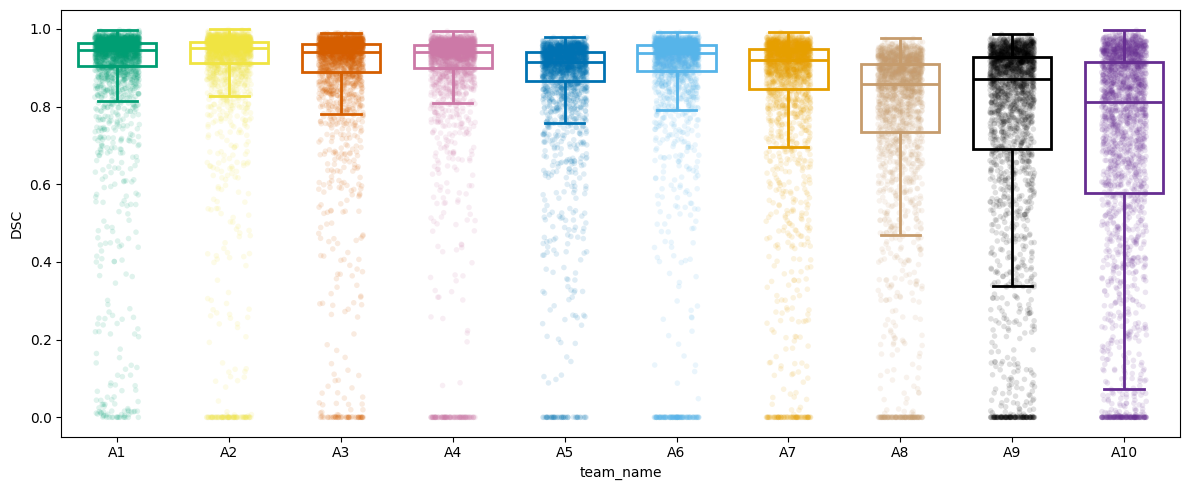

In [15]:
team_order = sorted(teams, key=lambda x: int(x[1:]))

team_colors = ["#009e73", "#f0e442", "#d55e00", "#cc79a7", "#0072b2","#56b4e9", "#e69f00", "#c69c6d", "#000000", "#662d91"]

palette = dict(zip(team_order, team_colors))

plot_df = robustmis_data.copy()
plot_df["team_name"] = pd.Categorical(plot_df["team_name"], categories=team_order, ordered=True)

plt.figure(figsize=(12, 5))

ax = sns.boxplot(data=plot_df, x="team_name", y="DSC", order=team_order, width=0.7, showfliers=False, linewidth=2)

for patch, team in zip(ax.patches, team_order):
    patch.set_facecolor((0, 0, 0, 0))    # transparent fill
    patch.set_edgecolor(palette[team])   # colored outline
    patch.set_linewidth(2)

# Color whiskers/caps/medians
for i, team in enumerate(team_order):
    for line in ax.lines:
        x = line.get_xdata()
        if len(x) == 0:
            continue
        
        if np.nanmin(x) >= i - 0.5 and np.nanmax(x) <= i + 0.5:
            line.set_color(palette[team])
            line.set_linewidth(2)

# Jittered points 
sns.stripplot(data=plot_df, x="team_name", y="DSC", order=team_order, hue="team_name",
              palette=palette, jitter=0.2, alpha=0.12, size=4, legend=False)

ax.set_xlabel("team_name")
ax.set_ylabel("DSC")

plt.tight_layout()
plt.savefig("figure_experiment3.pdf", bbox_inches="tight", dpi=300)
plt.show()